In [11]:
import pandas_datareader.data as web
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


## Load Data

In [12]:
def data_collection(ticker, start, end):
    
    df = web.get_data_yahoo(ticker, start, end)
        
    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

    return df

In [13]:
# Load Data
df = data_collection('AAPL', datetime.date(2019,1,1), datetime.date(2020,3,14))
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700.0,155.214005
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200.0,139.753540
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100.0,145.719513
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800.0,145.395203
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300.0,148.166870


## Prediction

### Model

In [14]:
def regression_channel(df, target, minimum, deviation):
    """
    Given a dataframe of stock price, get prediction of the stock price and the regression channel
    Inputs
        df         : dataframe with the values you want to predict
        target_col : name of the column you want to predict e.g. 'close'
        minimum    : all predictions should be >= pred_min, e.g. '0'
        deviation  : define how much deviation of the upper and lower line to the prediction 
    Outputs
        df with channel : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Defind the date as X and previous stock price as Y
    X = np.array(range(len(df[target]))).reshape(-1, 1)
    Y = np.array(df[target]).reshape(-1, 1)
    
    # Defind a regressor
    model = LinearRegression(fit_intercept = True)
    
    # Train the model
    model.fit(X, Y)   

    # Get the prediction value 
    pred_list = model.predict(X)
    # If the values are < pred_min, set it to be pred_min
    pred_list[pred_list < minimum] = minimum
    
    # Add prediction to df
    df_pred = df
    df_pred.loc[:, 'Prediction'] = pred_list
    
        
    # If deviation is bigger, the regression chanel is wider
    one_std = np.std(Y)
    df_pred.loc[:, 'Upper'] = pred_list + one_std*deviation
    df_pred.loc[:, 'Lower'] = pred_list - one_std*deviation
        
    return df_pred     
    

In [15]:
dev = 0.6
df_pred = regression_channel(df, 'close', 0, dev)
df_pred.head()

,high,low,open,close,volume,adj_close,Prediction,Upper,Lower
Date,,,,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700.0,155.214005,145.967240,175.108239,116.826241
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200.0,139.753540,146.488433,175.629432,117.347433
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100.0,145.719513,147.009625,176.150625,117.868626
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800.0,145.395203,147.530818,176.671817,118.389819
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300.0,148.166870,148.052011,177.193010,118.911012


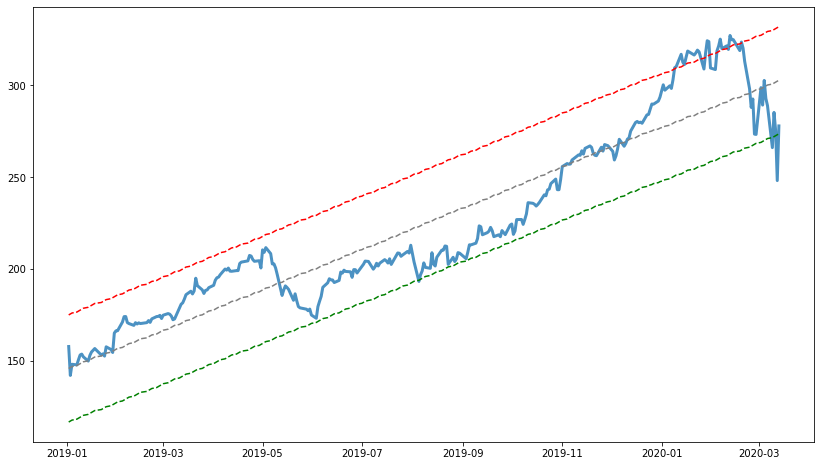

In [16]:
# Plot of Trading Singal
fig = plt.figure(figsize=(14,8))

plt.plot(df_pred[['close']], lw=3, alpha=0.8,  label = 'Close Price')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed', label = 'Prediction')
plt.plot(df_pred[['Upper']], color = 'red', linestyle='dashed', label = 'Upper Line')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed', label = 'Lower Line')

plt.show()


### Trade Signal

In [17]:
def trade_signal(df_pred):
    # Initialize the `signals` DataFrame with the `signal` column
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0

    # Add close price, lower and upper predicted price
    signals['price'] = df['close']
    signals['lower'] = df['Lower']
    signals['upper'] = df['Upper']

    # Create signals
    signals.loc[signals['price'] < signals['lower'], 'signal'] = 1.0
    signals.loc[signals['price'] > signals['upper'], 'signal'] = -1.0

    # Generate trading orders
    position = signals.loc[signals['signal'] != 0]
    position['position'] = position['signal'].diff()
    # If the first signal is 1.0, the position is 'buy'
    if position.loc[position.index.values[0], "signal"] == 1.0:
        position.loc[position.index.values[0], "position"] = 1.0

    # Combine the position and signal
    signals = signals.merge(position.position, how = "left", left_index=True, right_index=True).fillna(0)
    
    return(signals)
    

In [21]:
signals = trade_signal(df_pred)
signals.loc[signals['position'] != 0]

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,signal,price,lower,upper,position
Date,,,,,
2019-08-05,1.0,193.339996,193.962773,252.244772,1.0
2020-01-09,-1.0,309.630005,250.772787,309.054786,-2.0
2020-03-09,1.0,266.170013,271.620499,329.902498,2.0


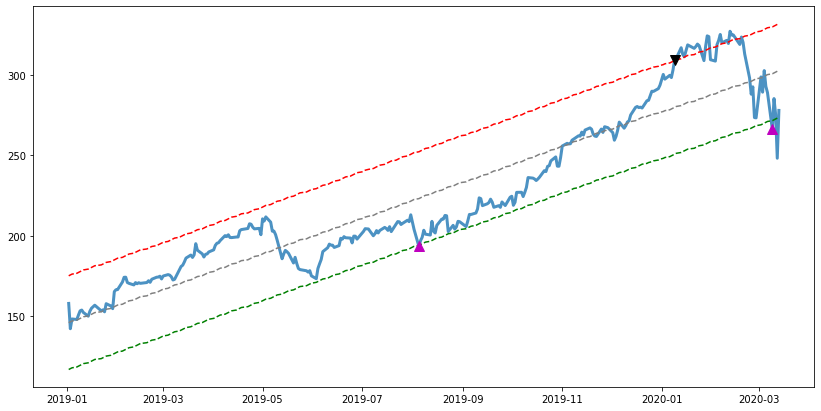

In [22]:
# Plot of Trading Singal
fig = plt.figure(figsize=(14,7))

plt.plot(df_pred[['close']], lw=3, alpha=0.8,  label = 'Close Price')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed', label = 'Prediction')
plt.plot(df_pred[['Upper']], color = 'red', linestyle='dashed', label = 'Upper Line')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed', label = 'Lower Line')

# Plot the buy signals
plt.plot(signals.loc[signals.position > 0].index,
          signals.price[signals.position > 0],
         '^', markersize=10, color='m', label='buy')

# Plot the sell signals
plt.plot(signals.loc[signals.position < 0].index,
          signals.price[signals.position < 0],
         'v', markersize=10, color='k', label='sell')

## Return

In [23]:
def trade_info(signals, cash):
    # Get the trade information from signal df
    trade_info = signals.loc[signals['position'] != 0]
    
    # Convert to trade action: Buy == 1 & Sell == -1.0
    trade_info.loc[trade_info['position'] > 0, 'action'] = 1.0
    trade_info.loc[trade_info['position'] < 0, 'action'] = -1.0
    
    # Check whether the first action is buy and the last action is sell
    if trade_info.loc[trade_info.index.values[0], 'action'] == -1:
        trade_info = trade_info.drop(trade_info.index[0])
    if len(trade_info) == 0:
        raise Exception("No signal!")
    if trade_info.loc[trade_info.index.values[len(trade_info)-1], 'action'] == 1.0:
        trade_info = trade_info.drop(trade_info.index[len(trade_info)-1])
    if len(trade_info) == 0:
        raise Exception("No signal!")
    
    
    # Select only price and action
    trade_info = trade_info[['price', 'action']]

    # Initialize the first trade
    trade_info.loc[trade_info.index.values[0], "cash_0"] = cash
    trade_info['quantity'] = trade_info['cash_0'] // trade_info['price'] 
    trade_info['value'] = trade_info['action']* trade_info['price'] * trade_info['quantity']
    trade_info['cash_1'] = trade_info['cash_0'] - trade_info['value']
    
    for i in range(1, len(trade_info)):
        # new cash_0
        trade_info.loc[trade_info.index.values[i], "cash_0"] = trade_info.loc[trade_info.index.values[i-1], "cash_1"]

        # trade quantity
        if(trade_info.loc[trade_info.index.values[i-1], "action"] == 1): 
            trade_info.loc[trade_info.index.values[i], "quantity"] = trade_info.loc[trade_info.index.values[i-1], "quantity"]
        else: 
            #trade_info['quantity'] = trade_info['cash_0'] // trade_info['price'] 
            trade_info.loc[trade_info.index.values[i], "quantity"] = trade_info.loc[trade_info.index.values[i], "cash_0"] // trade_info.loc[trade_info.index.values[i], "price"]

        # value
        trade_info['value'] = trade_info['action']* trade_info['price'] * trade_info['quantity']

        # cash_1
        trade_info['cash_1'] = trade_info['cash_0'] - trade_info['value']
        
    return trade_info
    
    

In [25]:
cash = 10000
trade = trade_info(signals, cash)
trade

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,price,action,cash_0,quantity,value,cash_1
Date,,,,,,
2019-08-05,193.339996,1.0,10000.000000,51.0,9860.339813,139.660187
2020-01-09,309.630005,-1.0,139.660187,51.0,-15791.130249,15930.790436


In [26]:
def gain_return(trade):
    gain = trade.loc[trade.index.values[len(trade)-1], "cash_1"] - trade.loc[trade.index.values[0], "cash_0"]
    inv_return = gain / trade.loc[trade.index.values[0], "cash_0"]
    
    data = {'Gain':[gain], 'Return': [inv_return]}
    out = pd.DataFrame(data)
    
    return out

In [28]:
gain = gain_return(trade).iloc[0][0]
inv_return = gain_return(trade).iloc[0][1]

print('Earning is: %.2f' %gain)
print("Return Rate is: %.2f%%" %(inv_return*100))

Earning is: 5930.79
Return Rate is: 59.31%


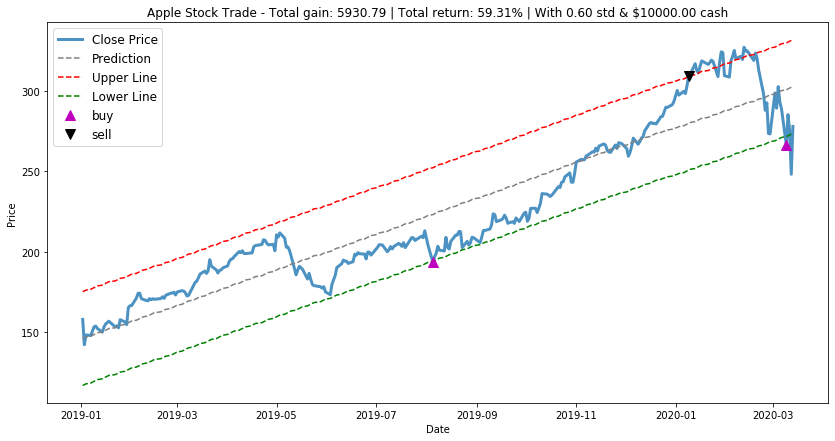

In [29]:
# Plot of Trading Singal
fig = plt.figure(figsize=(14,7))

plt.plot(df_pred[['close']], lw=3, alpha=0.8,  label = 'Close Price')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed', label = 'Prediction')
plt.plot(df_pred[['Upper']], color = 'red', linestyle='dashed', label = 'Upper Line')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed', label = 'Lower Line')

# Plot the buy signals
plt.plot(signals.loc[signals.position > 0].index,
          signals.price[signals.position > 0],
         '^', markersize=10, color='m', label='buy')

# Plot the sell signals
plt.plot(signals.loc[signals.position < 0].index,
          signals.price[signals.position < 0],
         'v', markersize=10, color='k', label='sell')

# Show the plot
plt.title('Apple Stock Trade - Total gain: %.2f | Total return: %.2f%% | With %.2f std & $%.2f cash' %(gain, (inv_return*100), dev, cash))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

##  Std comparison

In [462]:
# Load Data
df = data_collection('AAPL', datetime.date(2019,1,1), datetime.date(2020,3,14))
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700.0,155.214005
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200.0,139.753540
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100.0,145.719513
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800.0,145.395203
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300.0,148.166870


In [473]:
dev = 0.6
df_pred = regression_channel(df, 'close', 0, dev)
df_pred.head()

,high,low,open,close,volume,adj_close,Prediction,Upper,Lower
Date,,,,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700.0,155.214005,145.967240,175.108239,116.826241
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200.0,139.753540,146.488433,175.629432,117.347433
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100.0,145.719513,147.009625,176.150625,117.868626
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800.0,145.395203,147.530818,176.671817,118.389819
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300.0,148.166870,148.052011,177.193010,118.911012


In [474]:
signals = trade_signal(df_pred)
display(signals.loc[signals['position'] != 0])

cash = 10000
trade = trade_info(signals, cash)
display(trade)

gain = gain_return(trade).iloc[0][0]
inv_return = gain_return(trade).iloc[0][1]

print('Earning is: %.2f' %gain)
print("Return Rate is: %.2f%%" %inv_return)

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,signal,price,lower,upper,position
Date,,,,,
2019-08-05,1.0,193.339996,193.962773,252.244772,1.0
2020-01-09,-1.0,309.630005,250.772787,309.054786,-2.0
2020-03-09,1.0,266.170013,271.620499,329.902498,2.0


/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

,price,action,cash_0,quantity,value,cash_1
Date,,,,,,
2019-08-05,193.339996,1.0,10000.000000,51.0,9860.339813,139.660187
2020-01-09,309.630005,-1.0,139.660187,51.0,-15791.130249,15930.790436


Earning is: 5930.79
Return Rate is: 0.59%


In [467]:
from datetime import datetime

def index_to_datetime(index):
    ts = (index - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.utcfromtimestamp(ts)

In [475]:
date_buy = index_to_datetime(trade.index.values[0])
print(date_buy)

date_sell = index_to_datetime(trade.index.values[1])
print(date_sell)

2019-08-05 00:00:00
2020-01-09 00:00:00


/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.


In [476]:
trade_day = (date_sell - date_buy).days
trade_day

157

Text(0, 0.5, 'Price')

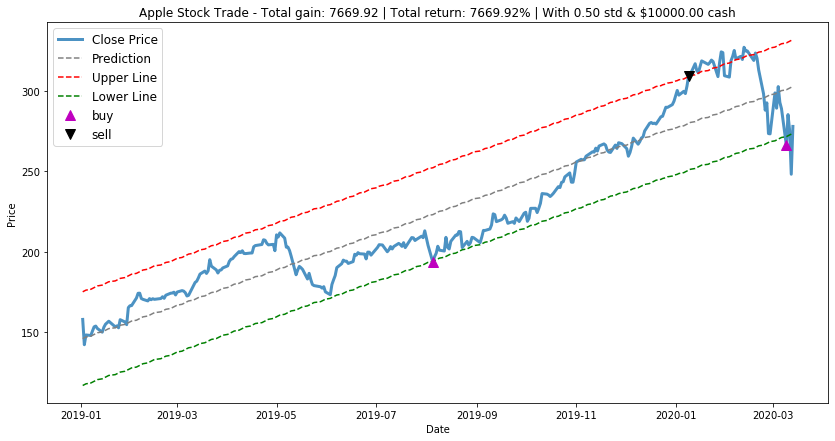

In [478]:
# Plot 1
fig = plt.figure(figsize=(14,7))

plt.plot(df_pred[['close']], lw=3, alpha=0.8,  label = 'Close Price')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed', label = 'Prediction')
plt.plot(df_pred[['Upper']], color = 'red', linestyle='dashed', label = 'Upper Line')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed', label = 'Lower Line')

# Plot the buy signals
plt.plot(signals.loc[signals.position > 0].index,
          signals.price[signals.position > 0],
         '^', markersize=10, color='m', label='buy')

# Plot the sell signals
plt.plot(signals.loc[signals.position < 0].index,
          signals.price[signals.position < 0],
         'v', markersize=10, color='k', label='sell')

# Show the plot
plt.title('Apple Stock Trade - Total gain: %.2f | Total return: %.2f%% | With %.2f std & $%.2f cash' %(gain_s, (inv_return_s*100), dev_s, cash))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Date")
plt.ylabel("Price")

## Time length comparison

In [48]:
# Load Data
df = data_collection('AAPL', datetime.date(2019,1,1), datetime.date(2019,2,1))
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700,155.214005
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200,139.753540
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100,145.719513
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800,145.395203
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300,148.166870


In [49]:
dev = 0.6
df_pred = regression_channel(df, 'close', 0, dev)
df_pred.head()

,high,low,open,close,volume,adj_close,Prediction,Upper,Lower
Date,,,,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700,155.214005,147.715611,151.139223,144.291999
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200,139.753540,148.383432,151.807043,144.959820
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100,145.719513,149.051252,152.474864,145.627641
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800,145.395203,149.719073,153.142684,146.295461
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300,148.166870,150.386893,153.810505,146.963282


In [50]:
signals = trade_signal(df_pred)
signals.loc[signals['position'] != 0]

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,signal,price,lower,upper,position
Date,,,,,
2019-01-03,1.0,142.190002,144.95982,151.807043,2.0
2019-01-30,-1.0,165.250000,156.98059,163.827813,-2.0


In [51]:
cash = 10000
trade = trade_info(signals, cash)
trade

/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

,price,action,cash_0,quantity,value,cash_1
Date,,,,,,
2019-01-03,142.190002,1.0,10000.000000,70.0,9953.300171,46.699829
2019-01-30,165.250000,-1.0,46.699829,70.0,-11567.500000,11614.199829


In [52]:
gain = gain_return(trade).iloc[0][0]
inv_return = gain_return(trade).iloc[0][1]

print('Earning is: %.2f' %gain)
print("Return Rate is: %.2f%%" %(inv_return*100))

Earning is: 1614.20
Return Rate is: 16.14%


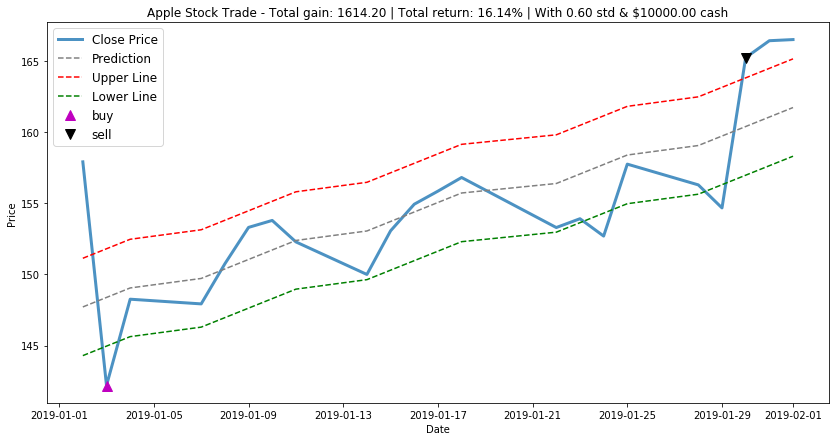

In [53]:
# Plot of Trading Singal
fig = plt.figure(figsize=(14,7))

plt.plot(df_pred[['close']], lw=3, alpha=0.8,  label = 'Close Price')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed', label = 'Prediction')
plt.plot(df_pred[['Upper']], color = 'red', linestyle='dashed', label = 'Upper Line')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed', label = 'Lower Line')

# Plot the buy signals
plt.plot(signals.loc[signals.position > 0].index,
          signals.price[signals.position > 0],
         '^', markersize=10, color='m', label='buy')

# Plot the sell signals
plt.plot(signals.loc[signals.position < 0].index,
          signals.price[signals.position < 0],
         'v', markersize=10, color='k', label='sell')

# Show the plot
plt.title('Apple Stock Trade - Total gain: %.2f | Total return: %.2f%% | With %.2f std & $%.2f cash' %(gain, (inv_return*100), dev, cash))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()